## Grape Disease Detection - CNN

Grapes are a type of fruit that is widely consumed and cultivated worldwide. However, vineyards can be exposed to various diseases, which can negatively affect both productivity and product quality. Detecting diseases with traditional methods is often time-consuming and laborious. In this context, the use of machine learning and deep learning techniques offers an important opportunity to ensure fast and accurate disease detection.

In this project, Convolutional Neural Networks (CNN) will be used to detect grape diseases. CNNs are a prominent deep learning architecture in the field of image processing and have the ability to automatically learn features from visual data. The aim of the project is to provide agricultural producers with a fast and effective solution by classifying different grape diseases.

<img src='grape.jpg' width=550 >

<a href='https://www.kaggle.com/datasets/rm1000/augmented-grape-disease-detection-dataset' target=_blank>You can find the data file here</a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'augmented-grape-disease-detection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2869270%2F4948090%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240921%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240921T065006Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D453a67fe15b6af2c0f45aa55f932c0b4817837cc6e681190a6d5ce200aa8f2b12b74fd7761e840a5d7123089abb1a7cd456d1f2441e58ed1420b6c1105e8597dd7291a3edfa64ab88b4a05319a7e9cd910b96f6c3dfbe8596ca7206f1a2004d22fee5f7a2a17d2711e1fb16a849a223a329ce40a976d1001667e373ea4fea66f48fa7cad74ff792c4d4668fd327eca4bd155f7cf7c1754ce0b9698caaad673f231160f0ac05473bce17a7f64fce15d8421845f3441e48e356d288cb9e86fea6c6a8db92c6036b5f92f87080ace069ed71ac4c344a398e8e6a213cafd86ec747989b2f806f7abdd6ce6572f5d33ae150d9ab21ebedd07de1eb46445912807fccf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 637381194 bytes downloaded
Downloaded and uncompressed: augmented-grape-disease-detection-dataset
Data source import complete.


### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Input, Reshape, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from IPython.display import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import warnings
warnings.filterwarnings('ignore')

### Determine the File Path

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Görüntülenen çıkış son 5000 satıra kısaltıldı.
/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/ESCA/40b6121e-4a4b-42de-822f-f7f9886476c3___FAM_B.Msls 1033_flipLR.JPG
/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/ESCA/_812_7000042.png
/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/ESCA/e4bedd05-5a16-4e64-8645-270831e82db0___FAM_B.Msls 0885.JPG
/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/ESCA/556f1dc2-4b17-4ac4-83ad-d449ad2989ce___FAM_B.Msls 1095_flipLR.JPG
/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/ESCA/31bd4f43-7895-46af-bead-3da25e5d650d___FAM_B.Msls 4459_flipLR.JPG
/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/ESCA/_200_7274294.png
/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/ESCA/46572386-7c18-4dcf-891a-04317add7685___FAM_B.Msls 1752_flipLR.JPG
/kaggle/input/augmented-grape

In [4]:
print(os.listdir('/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/'))

['Healthy', 'Leaf Blight', 'ESCA', 'Black Rot']


### Reading the pictures and labels

In [5]:
labels=['ESCA','Healthy','Leaf Blight','Black Rot']
img_path='/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/'

In [6]:
img_list=[]
label_list=[]
for label in labels:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)

In [7]:
df=pd.DataFrame({'img':img_list,'label':label_list})

In [8]:
df.head()

,img,label
0,/kaggle/input/augmented-grape-disease-detectio...,ESCA
1,/kaggle/input/augmented-grape-disease-detectio...,ESCA
2,/kaggle/input/augmented-grape-disease-detectio...,ESCA
3,/kaggle/input/augmented-grape-disease-detectio...,ESCA
4,/kaggle/input/augmented-grape-disease-detectio...,ESCA


In [10]:
df.sample(5)

,img,label
7559,/kaggle/input/augmented-grape-disease-detectio...,Leaf Blight
7642,/kaggle/input/augmented-grape-disease-detectio...,Leaf Blight
5530,/kaggle/input/augmented-grape-disease-detectio...,Healthy
6534,/kaggle/input/augmented-grape-disease-detectio...,Leaf Blight
2838,/kaggle/input/augmented-grape-disease-detectio...,ESCA


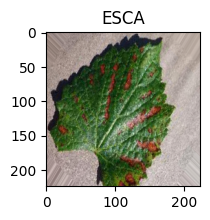

In [12]:
p='/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/ESCA/_1444_3406473.png'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(p))
plt.title('ESCA')
plt.show()

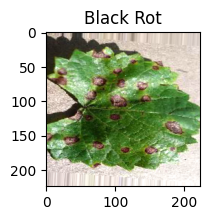

In [13]:
p='/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/Black Rot/_131_8188719.png'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(p))
plt.title('Black Rot')
plt.show()

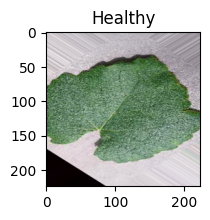

In [14]:
p='/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/Healthy/_272_6837373.png'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(p))
plt.title('Healthy')
plt.show()

### Label Encoding

In [15]:
d={'ESCA':0, 'Healthy':1, 'Leaf Blight':2, 'Black Rot':3}

In [16]:
df['encode_label']=df['label'].map(d)

In [17]:
df.sample(5)

,img,label,encode_label
9034,/kaggle/input/augmented-grape-disease-detectio...,Black Rot,3
6370,/kaggle/input/augmented-grape-disease-detectio...,Leaf Blight,2
3549,/kaggle/input/augmented-grape-disease-detectio...,Healthy,1
11321,/kaggle/input/augmented-grape-disease-detectio...,Black Rot,3
4217,/kaggle/input/augmented-grape-disease-detectio...,Healthy,1


In [18]:
x=[]
for img in df['img']:
    img=cv2.imread(img)
    img=cv2.resize(img,(32,32))
    img=img/255.0
    x.append(img)

### Modelling

In [19]:
x=np.array(x)

In [20]:
y=df['encode_label']

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)

In [23]:
model=Sequential()
model.add(Input(shape=(32,32,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(4,activation='softmax'))
early_stopping=EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [24]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=15,verbose=1,callbacks=[early_stopping])

Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.6795 - loss: 0.7499 - val_accuracy: 0.8379 - val_loss: 0.3829
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8517 - loss: 0.3651 - val_accuracy: 0.8842 - val_loss: 0.2963
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.9000 - loss: 0.2555 - val_accuracy: 0.9112 - val_loss: 0.2440
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9188 - loss: 0.2080 - val_accuracy: 0.9071 - val_loss: 0.2385
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9429 - loss: 0.1616 - val_accuracy: 0.9358 - val_loss: 0.1708
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9558 - loss: 0.1168 - val_accuracy: 0.9325 - val_loss: 0.1815
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9647 - loss: 0.0967 - val_accuracy: 0.9371 - val_loss: 0.1653
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9684 - loss: 0.0874 - 

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 944,846 (3.60 MB)

 Trainable params: 314,948 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 629,898 (2.40 MB)

In [26]:
loss,accuracy=model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9547 - loss: 0.1296
Test Loss: 0.15367640554904938
Test Accuracy: 0.9516666531562805


In [27]:
pred=model.predict(x_test)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [28]:
confusion_matrix(y_test,np.argmax(pred,axis=1))

array([[542,   0,   2,  68],
       [  0, 621,   1,   2],
       [  3,   0, 550,  15],
       [ 17,   2,   6, 571]])

In [29]:
print(classification_report(y_test, np.argmax(pred,axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       612
           1       1.00      1.00      1.00       624
           2       0.98      0.97      0.98       568
           3       0.87      0.96      0.91       596

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



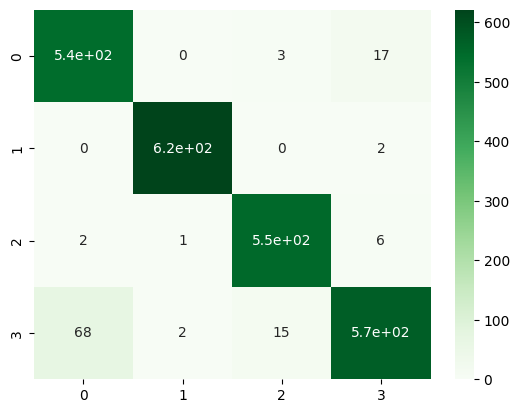

In [32]:
cm = confusion_matrix(np.argmax(pred,axis=1), y_test)
#normalized_cm = cm / cm.sum()
sns.heatmap(cm, annot=True, cmap='Greens');

In [33]:
model.save('grape_model.h5')

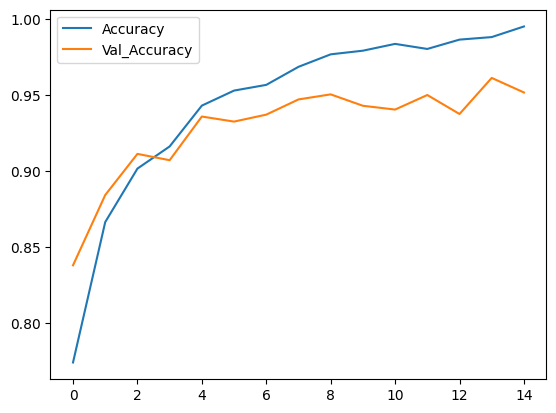

In [34]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend()

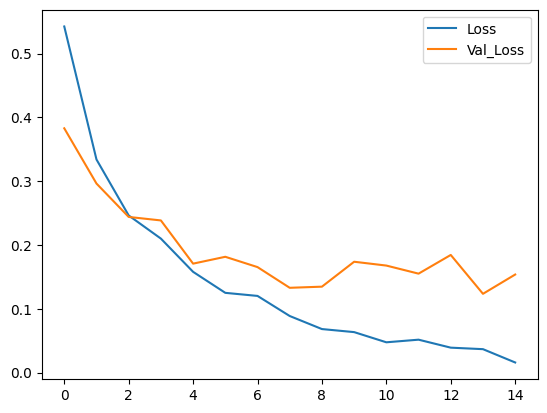

In [35]:
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val_Loss')
plt.legend()

## Transfer Learning

In [36]:
data_dir='/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data'

img_width,img_height=32,32
train_datagen=ImageDataGenerator(rescale=1/255,validation_split=.20)

train_datagenerator=train_datagen.flow_from_directory(directory=data_dir,target_size=(img_width,img_height),
                                class_mode='categorical', subset='training')

test_datagen=ImageDataGenerator(rescale=1/255)
test_datagenerator=train_datagen.flow_from_directory(directory=data_dir,target_size=(img_width,img_height),
                                class_mode='categorical', subset='validation')

base_model=VGG16(weights='imagenet', input_shape=(img_width,img_height,3),include_top=False)

model=Sequential()

model.add(base_model)
for layer in base_model.layers:
    layer.trainable=False

model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.fit(train_datagenerator,epochs=15,validation_data=test_datagenerator, callbacks=[early_stopping])

Found 9600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 155s 507ms/step - accuracy: 0.6637 - loss: 0.7882 - val_accuracy: 0.8125 - val_loss: 0.4597
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 216s 557ms/step - accuracy: 0.7973 - loss: 0.4964 - val_accuracy: 0.8188 - val_loss: 0.4488
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 162s 540ms/step - accuracy: 0.8120 - loss: 0.4446 - val_accuracy: 0.8263 - val_loss: 0.4286
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 192s 506ms/step - accuracy: 0.8378 - loss: 0.4013 - val_accuracy: 0.8121 - val_loss: 0.4392
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 201s 505ms/step - accuracy: 0.8553 - loss: 0.3695 - val_accuracy: 0.8417 - val_loss: 0.4005
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 150s 500ms/step - accuracy: 0.8652 - loss: 0.3298 - val_accuracy: 0.8438 - val_loss: 0.3926
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 200s 495ms/step - accuracy: 0.882

In [37]:
test_loss, test_acc=model.evaluate(test_datagenerator, verbose=2)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

75/75 - 28s - 369ms/step - accuracy: 0.8500 - loss: 0.4119
Test Accuracy: 0.8500000238418579
Test Loss: 0.41188400983810425


In [38]:
model.save('grape.keras')

### Predict the Images

In [217]:
img=image.load_img('/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/Healthy/_1478_2423317.png', target_size=(224,224))
img=image.img_to_array(img)
img=np.expand_dims(img, axis=0)

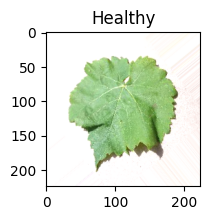

In [218]:
p='/kaggle/input/augmented-grape-disease-detection-dataset/Final Training Data/Healthy/_1478_2423317.png'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(p))
plt.title('Healthy')
plt.show()

In [110]:
model=VGG16(weights='imagenet')

In [219]:
pred=model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


In [220]:
decode_predictions(pred, top=1)

[[('n07715103', 'cauliflower', 0.48405325)]]

## Summary

In this project, we developed a Convolutional Neural Network (CNN) model for grape disease detection. We started the project by separating the data according to their labels. We used the label encoding method to read the images and convert the labels into numerical values. In this process, we displayed a few sample images by managing the labels through a dictionary that we defined.

Before moving on to model training, we preprocessed the data appropriately and then trained our CNN model. We examined the results using graphs, confusion matrix and classification report to evaluate the performance of the model. We saved the trained model to create a web application.

We also used a previously trained model by applying the transfer learning method. Finally, we tested the success rate of our model using the decode and predict functions to make predictions. Thus, the project was completed and we managed to provide an effective solution for grape disease detection.